# Thematic differences (Ukraine)

DHH23 Parliament group

Author: Pontus H.

In [59]:
# Set the theme here
THEME = 'war_UA'
# Set the output path for the CSV:s and keyword figure
OUTPUT_PATH = '../thematic_differences/'
# Set the output path for the model
MODEL_PATH = '../data/models/'

In [60]:
from cuml.manifold import UMAP
from cuml.cluster.hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

import pandas as pd

In [61]:
# Optional stopwords
with open('../data/stopwords-ua.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

Set up the BERTopic pipeline

In [63]:
df = pd.read_csv(f'../data/{THEME}.csv')
df.head()

,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,...,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth,speech,speech_split,sentiment,speech_length
0,ParlaMint-UA_2017-01-18-m0.u16,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2017-01-18,Unicameralism,8,5,NaN,2017-01-18,NaN,Reference,...,NaN,NaN,NaN,"Володимирівна Геращенко, Ірина",F,1971.0,"Шановні колеги, ви знаєте, наприкінці грудня в...",І дозвольте привернути вашу увагу на неприпус...,-1.000000,2695
1,ParlaMint-UA_2017-01-18-m0.u35,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2017-01-18,Unicameralism,8,5,NaN,2017-01-18,NaN,Reference,...,NaN,NaN,NaN,"Іванівна Сироїд, Оксана",F,1976.0,"Я передовсім звертаюся до секретаріату, щоби п...","Будь ласка, поставте, будь ласка, відео. Я хо...",-0.289307,3277
2,ParlaMint-UA_2017-01-18-m0.u57,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2017-01-18,Unicameralism,8,5,NaN,2017-01-18,NaN,Reference,...,фВОБ,Фракція політичної партії Всеукраїнське об'єдн...,Opposition,"Михайлович Немиря, Григорій",M,1960.0,"Дякую. Дякую, колезі Іллєнку за слушний комент...","Дякую, колезі Іллєнку за слушний коментар і з...",-0.157471,567
3,ParlaMint-UA_2017-01-18-m0.u67,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2017-01-18,Unicameralism,8,5,NaN,2017-01-18,NaN,Reference,...,фБПП,Фракція партії «Блок Петра Порошенка»,Coalition,"Абдурахманович Чубаров, Рефат",M,1957.0,"Шановна Голова! Шановні колеги! Мій виступ, мо...","Відомо, що темрява посилюється перед світанко...",-0.533203,1759
4,ParlaMint-UA_2017-01-18-m0.u69,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2017-01-18,Unicameralism,8,5,NaN,2017-01-18,NaN,Reference,...,фОпоблок,"Фракція політичної партії ""Опозиційний блок""",Opposition,"Іванович Німченко, Василь",M,1950.0,"Оппозиционный блок, Нимченко. Уважаемые коллег...","Уважаемые коллеги, я думаю, что этот законопр...",-0.978516,1250


In [62]:
# Parameters
HDBSCAN_MIN_CLUSTER_SIZE = int(np.sqrt(len(df)))
HDBSCAN_MIN_SAMPLES = 1
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0
OUTLIER_THRESHOLD = 0.1

# Step 1 - Extract embeddings
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2') # English
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2') # Other languages

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,)

# Step 3 - Cluster reduced embeddings with KMeans
# hdbscan_model = KMeans(n_clusters=100, random_state=42)

# Step 4 - Tokenize topics
# vectorizer_model = CountVectorizer(stop_words="english") # English
vectorizer_model = CountVectorizer(stop_words=stopwords) # Other languages

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.8)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  # nr_topics=10,
  calculate_probabilities=True,
  n_gram_range=(1, 3)
)

In [64]:
df['Speaker_party'].value_counts()

фВОБ              944
фБПП              627
фНФ               608
фЛяшко            588
фЄС               565
фСН               371
фОС               325
фПГ               298
фОПЗЖ             233
фСвобода          216
фОпоблок          193
гДовіра           193
гЗМП              177
фУДАР             118
фПР                75
гСЄУ               55
гЕР                52
гВН                46
гПВ                32
НФ                 25
гЗМіС              25
БПП                15
Свобода            12
фКПУ                4
УСГ                 3
фОпоблок;фОПЗЖ      3
фБЮТ                2
фБПП;фЄС            1
фНФ;фЄС             1
Name: Speaker_party, dtype: int64

In [65]:
# Reference running time for this cell: 0min 30s
topics, probs = topic_model.fit_transform(df['speech'])


In [66]:
pd.Series(topics).value_counts()

-1     3177
 0      969
 1      376
 2      278
 3      217
 4      198
 5      193
 6      193
 7      188
 8      162
 9      148
 10     125
 11     120
 12     114
 13     100
 15      71
 14      71
 16      65
 17      62
 18      60
 19      57
 20      53
 21      52
 22      52
dtype: int64

In [67]:
# Reduce outliers
# threshold reduced to 0.05 from 0.1
new_topics = topic_model.reduce_outliers(df['speech'], topics, strategy="c-tf-idf", threshold=OUTLIER_THRESHOLD)

In [68]:
pd.Series(new_topics).value_counts()

 0     1152
 1      856
 2      672
 3      618
 7      411
 4      316
 6      315
 5      285
 8      277
 9      259
 11     254
 10     215
 13     207
-1      174
 12     155
 18     130
 15     128
 21     123
 14     108
 20     105
 17     105
 19      86
 16      77
 22      73
dtype: int64

In [69]:
#topic_model.save(f"../data/topic_model_epsilon{HDBSCAN_CLUSTER_SELECTION_EPSILON}_clustersize{HDBSCAN_MIN_CLUSTER_SIZE}.bin")

In [70]:
#topic_model = BERTopic.load("../data/topic_model_epsilon0_clustersize50.bin")

In [71]:
# Number of topics
print(f"Number of topics: {len(pd.Series(topics).unique())}")

Number of topics: 24


In [72]:
# The count of speeches per topic. -1 is the noise(outlier) topic
pd.Series(topic_model.hdbscan_model.labels_).value_counts()

-1     3177
 11     969
 10     376
 2      278
 6      217
 7      198
 12     193
 3      193
 21     188
 19     162
 4      148
 18     125
 14     120
 13     114
 1      100
 20      71
 16      71
 17      65
 22      62
 15      60
 9       57
 0       53
 8       52
 5       52
dtype: int64

In [73]:
topic_model.visualize_topics()

In [74]:
topic_word_scores = topic_model.visualize_barchart(width=330, height=330, top_n_topics=10, n_words=10)
# Create the output directory if it does not exist
import os
if not os.path.exists(f"{OUTPUT_PATH}{THEME}"):
    os.makedirs(f"{OUTPUT_PATH}{THEME}")
topic_word_scores.write_image(f"{OUTPUT_PATH}{THEME}/{THEME}_topic_keywords.png")
topic_word_scores

# Word Clouds

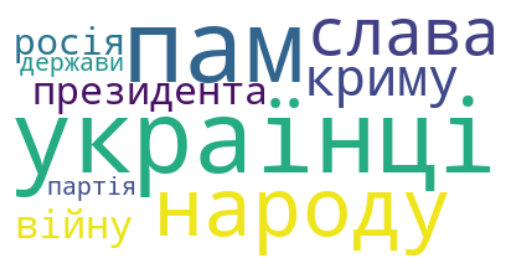

In [75]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

For the top 10 topics, get the percentage of Labour speeches and Conservative speeches. Include the keywords related to the topic.

In [76]:
def get_keywords(topic):
    return [word for word, _ in topic_model.get_topic(topic)]
# get_keywords(0)

In [77]:
speech_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party']})
# Remove the noise topic
speech_topic_party = speech_topic_party[speech_topic_party['topic'] != -1]
# Remove topics > 10
speech_topic_party = speech_topic_party[speech_topic_party['topic'] < 10]
# Drop speeches with no party
speech_topic_party = speech_topic_party.dropna()
# Set the party name to 'фБПП.фЄС.фУДАР' if it contains 'фБПП', 'фЄС' or 'фУДАР'
speech_topic_party.loc[speech_topic_party['party'].str.contains('фБПП|фЄС|фУДАР'), 'party'] = 'фБПП.фЄС.фУДАР'
# Set the party name to 'фОПЗЖ.фОпоблок.фПР' if it contains 'фОПЗЖ', 'фОпоблок' or 'фПР'
speech_topic_party.loc[speech_topic_party['party'].str.contains('фОПЗЖ|фОпоблок|фПР'), 'party'] = 'фОПЗЖ.фОпоблок.фПР'
# Set the party name to 'OTHER' if the party name does not contain 'SDS' or 'SD'
speech_topic_party.loc[~speech_topic_party['party'].str.contains('фБПП.фЄС.фУДАР|фОПЗЖ.фОпоблок.фПР'), 'party'] = 'OTHER'
# Group by party and topic
speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
speech_topic_party = speech_topic_party.pivot(index='topic', columns='party', values='counts').fillna(0)
#speech_topic_party.to_csv(f"{OUTPUT_PATH}{THEME}_speeches_topic_party.csv")
speech_topic_party

party,OTHER,фБПП.фЄС.фУДАР,фОПЗЖ.фОпоблок.фПР
topic,,,
0,686,193,47
1,469,168,43
2,397,145,26
3,310,98,68
4,179,64,11
5,144,73,20
6,180,65,11
7,213,105,35
8,145,65,27


In [78]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages = speech_topic_party.div(speech_topic_party.sum(axis=0), axis=1)
# Multiply by 100 to get percentages and round to 1 decimal
percentages = (percentages * 100).round(1)
percentages.reset_index()
percentages

party,OTHER,фБПП.фЄС.фУДАР,фОПЗЖ.фОпоблок.фПР
topic,,,
0,23.7,18.9,15.5
1,16.2,16.5,14.1
2,13.7,14.2,8.6
3,10.7,9.6,22.4
4,6.2,6.3,3.6
5,5.0,7.2,6.6
6,6.2,6.4,3.6
7,7.4,10.3,11.5
8,5.0,6.4,8.9


In [79]:
# Reset the index to get the topic column back and add a new column 'keywords'
percentages = percentages.reset_index()
percentages['keywords'] = percentages['topic'].apply(lambda x: get_keywords(x))
percentages = percentages.set_index('topic')
#percentages.to_csv(f'{OUTPUT_PATH}{THEME}_percentages.csv')
percentages

party,OTHER,фБПП.фЄС.фУДАР,фОПЗЖ.фОпоблок.фПР,keywords
topic,,,,
0,23.7,18.9,15.5,"[українці, пам, народу, слава, криму, президен..."
1,16.2,16.5,14.1,"[федерації, виборів, обсє, республіки, тимчасо..."
2,13.7,14.2,8.6,"[зброї, національної, україни, змін, гвардії, ..."
3,10.7,9.6,22.4,"[рішення, виборів, парламенті, закони, людей, ..."
4,6.2,6.3,3.6,"[батьківщина, хочу, війни, читання, інвалідів,..."
5,5.0,7.2,6.6,"[народу, подякувати, незалежності, українці, п..."
6,6.2,6.4,3.6,"[правосуддя, питання, прокурор, генерального, ..."
7,7.4,10.3,11.5,"[бюджету, гроші, 2023, оборони, уряд, дороги, ..."
8,5.0,6.4,8.9,"[читання, законопроекту, голосувати, давайте, ..."


In [80]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages_per_row = speech_topic_party.div(speech_topic_party.sum(axis=1), axis=0)
# Multiply by 100 to get percentages and round to 1 decimal
percentages_per_row = (percentages_per_row * 100).round(1)
# percentages_per_row.to_csv(f'{OUTPUT_PATH}{THEME}_percentages_per_row.csv')
percentages_per_row.reset_index()

party,topic,OTHER,фБПП.фЄС.фУДАР,фОПЗЖ.фОпоблок.фПР
0,0,74.1,20.8,5.1
1,1,69.0,24.7,6.3
2,2,69.9,25.5,4.6
3,3,65.1,20.6,14.3
4,4,70.5,25.2,4.3
5,5,60.8,30.8,8.4
6,6,70.3,25.4,4.3
7,7,60.3,29.7,9.9
8,8,61.2,27.4,11.4
9,9,73.9,19.0,7.1


Calculate mean sentiment for each topic per party

In [81]:
# sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party'], 'sentiment': df['sentiment']})
sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'speech_id': df['ID'], 'party': df['Speaker_party'], 'speaker_party': df['Speaker_party'], 'sentiment': df['sentiment'], 'speech_date': df['Date'], 'prob': list(probs), 'speech': df['speech']})
# Remove the noise topic
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] != -1]
# Remove topics > 10
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] < 10]
# Drop speeches with no party
sentiment_topic_party = sentiment_topic_party.dropna()
# Set the party name to 'фБПП.фЄС.фУДАР' if it contains 'фБПП', 'фЄС' or 'фУДАР'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('фБПП|фЄС|фУДАР'), 'party'] = 'фБПП.фЄС.фУДАР'
# Set the party name to 'фОПЗЖ.фОпоблок.фПР' if it contains 'фОПЗЖ', 'фОпоблок' or 'фПР'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('фОПЗЖ|фОпоблок|фПР'), 'party'] = 'фОПЗЖ.фОпоблок.фПР'
# Set the party name to 'OTHER' if the party name does not contain 'SDS' or 'SD'
sentiment_topic_party.loc[~sentiment_topic_party['party'].str.contains('фБПП.фЄС.фУДАР|фОПЗЖ.фОпоблок.фПР'), 'party'] = 'OTHER'
# Create a new dataframe with the relevant speeches and remove
relevant_speeches = sentiment_topic_party.copy()
sentiment_topic_party.drop(columns=['speech', 'speech_date', 'prob'], inplace=True)
# Group by party and topic and take the average sentiment
sentiment_topic_party = sentiment_topic_party.groupby(['topic', 'party']).mean().reset_index()
# speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
sentiment_topic_party = sentiment_topic_party.pivot(index='topic', columns='party', values='sentiment').fillna(0).round(2)
# sentiment_topic_party.to_csv(f'{OUTPUT_PATH}{THEME}_sentiment.csv')
sentiment_topic_party

party,OTHER,фБПП.фЄС.фУДАР,фОПЗЖ.фОпоблок.фПР
topic,,,
0,-0.61,-0.61,-0.57
1,-0.31,-0.34,-0.50
2,-0.15,-0.20,-0.44
3,-0.53,-0.41,-0.58
4,-0.35,-0.39,-0.75
5,0.05,-0.05,0.13
6,-0.59,-0.74,-0.21
7,-0.37,-0.45,-0.43
8,-0.36,-0.34,-0.35


In [82]:
# Save the topic model
topic_model.save(f"{MODEL_PATH}{THEME}_topic_model.bin")

In [83]:
def get_top_3(topic_id, party_name):
    speeches_for_topic_0_con = relevant_speeches[(relevant_speeches['party'] == party_name) & (relevant_speeches['topic'] == topic_id)]
    speeches_for_topic_0_con['prob'] = speeches_for_topic_0_con['prob'].apply(lambda x: x[topic_id])
    speeches_for_topic_0_con = speeches_for_topic_0_con.sort_values(by='sentiment', ascending=False)
    most_positive = speeches_for_topic_0_con.head(3)
    most_negative = speeches_for_topic_0_con.tail(3)
    return most_positive.append(most_negative).drop_duplicates(subset=['speech_id'])

parties = ['фБПП.фЄС.фУДАР', 'фОПЗЖ.фОпоблок.фПР', 'OTHER']

max_topic = relevant_speeches['topic'].max()

representative_speeches = get_top_3(0, 'фБПП.фЄС.фУДАР')
for party in parties[1:]:
    representative_speeches = representative_speeches.append(get_top_3(0, party))
for topic_id in range(1,max_topic+1):
    for party in parties:
        representative_speeches = representative_speeches.append(get_top_3(topic_id, party))

# Save the representative speeches to a csv and feather file. Use '"" as the quotechar to avoid issues with the speech text
representative_speeches.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_representative_speeches.csv', quotechar='"', index=False)
representative_speeches.reset_index().to_feather(f'{OUTPUT_PATH}{THEME}/{THEME}_representative_speeches.feather')
representative_speeches

,topic,speech_id,party,speaker_party,sentiment,speech_date,prob,speech
3682,0,ParlaMint-UA_2020-05-20-m0.u22,фБПП.фЄС.фУДАР,фЄС,0.721191,2020-05-20,0.129541,Сьогодні у нас рівно рік повноважень Президент...
1030,0,ParlaMint-UA_2021-05-21-m0.u158,фБПП.фЄС.фУДАР,фЄС,0.658691,2021-05-21,0.988660,"Доброго дня, шановні колеги! У нинішній війні ..."
5685,0,ParlaMint-UA_2018-01-16-m1.u74,фБПП.фЄС.фУДАР,фБПП,0.606445,2018-01-16,0.290178,"Україна, Збройні Сили України, громадяни Украї..."
5558,0,ParlaMint-UA_2018-07-06-m0.u96,фБПП.фЄС.фУДАР,фБПП,-1.000000,2018-07-06,0.179718,Слава Ісусу Христу! Мене як громадянина Україн...
732,0,ParlaMint-UA_2021-05-19-m0.u157,фБПП.фЄС.фУДАР,фЄС,-1.000000,2021-05-19,0.353769,На вас зараз дивляться убиті українські десант...
...,...,...,...,...,...,...,...,...
362,9,ParlaMint-UA_2017-07-14-m0.u108,OTHER,фЛяшко,0.728027,2017-07-14,0.057946,"Шановний український народе, шановні колеги на..."
4650,9,ParlaMint-UA_2023-02-23-m0.u199,OTHER,фСН,0.699707,2023-02-23,0.284632,"Добрий день, шановні колеги! Ми всі з вами зар..."
1545,9,ParlaMint-UA_2022-09-21-m0.u24,OTHER,фВОБ,-1.000000,2022-09-21,0.071896,"Шановні колеги, хотіла б з вами трохи поговори..."
61,9,ParlaMint-UA_2017-02-10-m0.u137,OTHER,фЛяшко,-1.000000,2017-02-10,0.053049,"Шановні українці вітаю вас! Для того, щоб підв..."


In [84]:
# Create a new dataframe from percentages, percentages_per_row and sentiment_topic_party
concatenated_results = pd.concat([percentages, percentages_per_row, sentiment_topic_party], axis=1)
# Rename the columns to make it easier to understand
concatenated_results.columns = ['pf.OTHER', 'pf.фБПП.фЄС.фУДАР', 'pf.фОПЗЖ.фОпоблок.фПР', 'keywords', 'tc.OTHER', 'tc.фБПП.фЄС.фУДАР', 'tc.фОПЗЖ.фОпоблок.фПР', 's.OTHER', 's.фБПП.фЄС.фУДАР', 's.фОПЗЖ.фОпоблок.фПР']
# Reorder the columns
concatenated_results = concatenated_results[['keywords', 'tc.фБПП.фЄС.фУДАР', 'tc.фОПЗЖ.фОпоблок.фПР', 'tc.OTHER', 'pf.фБПП.фЄС.фУДАР', 'pf.фОПЗЖ.фОпоблок.фПР', 'pf.OTHER', 's.фБПП.фЄС.фУДАР', 's.фОПЗЖ.фОпоблок.фПР', 's.OTHER']]
# Save the results to a csv
concatenated_results.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_results.csv')
concatenated_results

,keywords,tc.фБПП.фЄС.фУДАР,tc.фОПЗЖ.фОпоблок.фПР,tc.OTHER,pf.фБПП.фЄС.фУДАР,pf.фОПЗЖ.фОпоблок.фПР,pf.OTHER,s.фБПП.фЄС.фУДАР,s.фОПЗЖ.фОпоблок.фПР,s.OTHER
topic,,,,,,,,,,
0,"[українці, пам, народу, слава, криму, президен...",20.8,5.1,74.1,18.9,15.5,23.7,-0.61,-0.57,-0.61
1,"[федерації, виборів, обсє, республіки, тимчасо...",24.7,6.3,69.0,16.5,14.1,16.2,-0.34,-0.50,-0.31
2,"[зброї, національної, україни, змін, гвардії, ...",25.5,4.6,69.9,14.2,8.6,13.7,-0.20,-0.44,-0.15
3,"[рішення, виборів, парламенті, закони, людей, ...",20.6,14.3,65.1,9.6,22.4,10.7,-0.41,-0.58,-0.53
4,"[батьківщина, хочу, війни, читання, інвалідів,...",25.2,4.3,70.5,6.3,3.6,6.2,-0.39,-0.75,-0.35
5,"[народу, подякувати, незалежності, українці, п...",30.8,8.4,60.8,7.2,6.6,5.0,-0.05,0.13,0.05
6,"[правосуддя, питання, прокурор, генерального, ...",25.4,4.3,70.3,6.4,3.6,6.2,-0.74,-0.21,-0.59
7,"[бюджету, гроші, 2023, оборони, уряд, дороги, ...",29.7,9.9,60.3,10.3,11.5,7.4,-0.45,-0.43,-0.37
8,"[читання, законопроекту, голосувати, давайте, ...",27.4,11.4,61.2,6.4,8.9,5.0,-0.34,-0.35,-0.36
